# Random Number Generation Experiments


![RNG diagram](../rng.png)


## Introduction

This notebook sets up experiments comparing different methods for training language models to generate random numbers from specified distributions.

We will focus on sampling numbers from various distributions.

The models we will compare are:

- GFN-fine-tuned LM: Fine-tuned via generative flow networks
- Likelihood-trained LM: Supervised-fine-tuned LM
- RL-tuned LM: Fine-tuned via reinforcement learning (PPO)


Several axes of experimentation:

- vary the distribution
  - discrete: uniform, Poisson, Binomial, Geometric, etc
  - continuous: uniform, Gaussian, exponential, etc
- vary the hyperparameters of the distribution (in the context)
  - Uniform: between 0 and `n_max`
  - Poisson: `lambda` between `λ_min` and `λ_max`
  - etc
- vary the prompt
  - 'Randomly generate (uniformly) one single random integer between 0 and {num_test}, and then stop: '
  - 'Randomly generate (uniformly) one single random integer in the interval [0, {num_test}]: '
  - 'Here is one single random integer sampled uniformly between 0 and {num_test}: '
  - "The following is a random integer drawn uniformly between 0 and {num_test}: "
  - etc
- vary the model
  - GFN-LM
  - PPO
  - MLE (SFT)


## General imports


In [ ]:
import os
import sys
import hydra
from hydra.experimental import initialize, compose
import wandb

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F
from peft import LoraConfig, get_peft_model, PeftModel

from rng.rng_utils import generate, generate_and_return_eos_logprob

In [ ]:
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
import shutil

import seaborn as sns
from IPython.display import display, Markdown

# # Remove the matplotlib cache
# shutil.rmtree(matplotlib.get_cachedir())

fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# print the names of all fonts
font_names = [matplotlib.font_manager.get_font(x).family_name for x in fonts]
print(font_names)

fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
print(fonts)
print("Times New Roman" in fonts)

plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rc("font", family="Times New Roman")

print(matplotlib.get_configdir())
print(matplotlib.get_cachedir())

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!nvidia-smi

Thu Sep 28 23:56:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:0F:00.0 Off |                    0 |
| N/A   25C    P0              60W / 400W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [7]:
import gc

with torch.no_grad():
    gc.collect()
    torch.cuda.empty_cache()

# Load the pretrained model


In [ ]:
# Initialize Hydra
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="multiobjective-lm/rng/configs")
cfg = compose(config_name="config")

bsz = cfg.hparams.GFN.bsz
grad_acc = cfg.hparams.grad_acc
lr = cfg.hparams.lr
warmup_steps = cfg.hparams.warmup_steps
subtb_lambda = cfg.hparams.GFN.subtb_lambda
max_len = cfg.hparams.max_len
min_len = cfg.hparams.min_len
eval_interval = cfg.hparams.eval_interval
log_interval = cfg.hparams.log_interval
model_to_use = cfg.hparams.model_to_use
seed = cfg.hparams.seed
save_dir = cfg.hparams.save_dir
epochs = cfg.hparams.epochs

In [10]:
# Set the seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
if model_to_use == "gpt-j":
    tokenizer = AutoTokenizer.from_pretrained("nlpcloud/instruct-gpt-j-fp16")
    model = AutoModelForCausalLM.from_pretrained(
        "nlpcloud/instruct-gpt-j-fp16", torch_dtype=torch.bfloat16
    )
elif model_to_use == "gpt2":
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    model = AutoModelForCausalLM.from_pretrained("gpt2")

model.to("cuda")

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f)

# Training


## LoRA, Optimizer


In [12]:
lora_config = LoraConfig(
    r=cfg.lora.r,
    lora_alpha=cfg.lora.lora_alpha,
    target_modules=["k_proj", "v_proj"] if model_to_use == "gpt-j" else ["c_attn"],
    lora_dropout=cfg.lora.lora_dropout,
    bias=cfg.lora.bias,
)
inference_model = get_peft_model(model, lora_config)

opt = torch.optim.AdamW(
    [{"params": inference_model.parameters(), "lr": lr}],
    betas=(cfg.adamw.b1, cfg.adamw.b2),
)


# learning rate schedule
def get_lr_mult_at_step(step):
    if step <= warmup_steps:
        return min(step / warmup_steps, 1.0)
    return max((total_steps - step) / (total_steps - warmup_steps), 0)


sched = torch.optim.lr_scheduler.LambdaLR(opt, get_lr_mult_at_step)

## Dataloader and Scheduler


In [13]:
from rng.rng_dataset import get_dataloader_from_dataframe

df_train = pd.read_csv(cfg.file_name.train)

train_loader = get_dataloader_from_dataframe(df_train, tokenizer, bsz=bsz, shuffle=True)

Tokenizing dataset...: 4096it [00:01, 2747.80it/s]


In [14]:
total_steps = epochs * len(train_loader)


# learning rate schedule
def get_lr_mult_at_step(step):
    if step <= warmup_steps:
        return min(step / warmup_steps, 1.0)
    return max((total_steps - step) / (total_steps - warmup_steps), 0)


sched = torch.optim.lr_scheduler.LambdaLR(opt, get_lr_mult_at_step)

## Tests


In [15]:
num_test = 10
print("Tokenized num_test: ", tokenizer.encode(str(num_test)), "\n\n")


def test_prompt(prompt_test, num_test=num_test):
    tokenzed_prompt_test = tokenizer(prompt_test, return_tensors="pt").to("cuda")
    print(
        f"Tokenized prompt '{prompt_test}': \n\t",
        "|".join(
            tokenizer.decode(t) for t in tokenzed_prompt_test["input_ids"].tolist()[0]
        ),
        "\n\t",
        tokenzed_prompt_test["input_ids"].tolist()[0],
        "\n\t",
        "\t ⟶ Contains tokenized `num_test`? ",
        num_test in tokenzed_prompt_test["input_ids"].tolist()[0],
        "\n",
        "Model response: \n\t",
        [
            tokenizer.decode(t)
            for t in model.generate(
                **tokenzed_prompt_test,
                max_new_tokens=30,
                temperature=0,
                pad_token_id=tokenizer.eos_token_id,
            )[0][len(tokenizer.encode(prompt_test)) :]
        ],
        "\n\n\n",
    )


prompt_tests = [
    f"Randomly generate (uniformly) one single random integer between 0 and {num_test}, and then stop: ",
    f"Randomly generate (uniformly) one single random integer in the interval [0, {num_test}]: ",
    f"Here is one single random integer sampled uniformly between 0 and {num_test}: ",
    f"The following is a random integer drawn uniformly between 0 and {num_test}: ",
]

for prompt_test in prompt_tests:
    test_prompt(prompt_test)

Tokenized num_test:  [940] 




Tokenized prompt 'Randomly generate (uniformly) one single random integer between 0 and 10, and then stop: ': 
	 Random|ly| generate| (|un|iform|ly|)| one| single| random| integer| between| 0| and| 10|,| and| then| stop|:|  
	 [29531, 306, 7716, 357, 403, 6933, 306, 8, 530, 2060, 4738, 18253, 1022, 657, 290, 838, 11, 290, 788, 2245, 25, 220] 
	 	 ⟶ Contains tokenized `num_test`?  False 
 Model response: 
	 [' the', ' number', ' you', ' generated', '.', '\n', '<|endoftext|>'] 



Tokenized prompt 'Randomly generate (uniformly) one single random integer in the interval [0, 10]: ': 
	 Random|ly| generate| (|un|iform|ly|)| one| single| random| integer| in| the| interval| [|0|,| 10|]:|  
	 [29531, 306, 7716, 357, 403, 6933, 306, 8, 530, 2060, 4738, 18253, 287, 262, 16654, 685, 15, 11, 838, 5974, 220] 
	 	 ⟶ Contains tokenized `num_test`?  False 
 Model response: 
	 [' \\', 'n', '\\', 'n', 'The', ' randomly', ' generated', ' integer', ' is', ':', ' 8', '\n', '<|endoftext|>'] 



Tokenized pr

In [18]:
numbers = range(1, 1001)

num_more_than_one_token = (
    (num, tokens) for num in numbers if len(tokens := tokenizer.encode(str(num))) > 1
)

first_number_more_than_one, first_number_more_than_one_token = next(
    num_more_than_one_token
)
print(
    f"The first number that requires more than 1 token is: {first_number_more_than_one, first_number_more_than_one_token}"
)
print(
    f"The second number that requires more than 1 token is: {next(num_more_than_one_token)}"
)
print(
    f"The third number that requires more than 1 token is: {next(num_more_than_one_token)}"
)

The first number that requires more than 1 token is: (521, [20, 2481])
The second number that requires more than 1 token is: (527, [20, 1983])
The third number that requires more than 1 token is: (531, [20, 3132])


In [20]:
num_tokens = [tokenizer.encode(str(num)) for num in range(first_number_more_than_one)]

allowed_indices = torch.tensor(
    [token for sublist in num_tokens for token in sublist], device="cuda"
)

vocab_nice_list = torch.zeros(len(tokenizer.vocab), device="cuda").bool()
vocab_nice_list[allowed_indices] = True
vocab_nice_list[tokenizer.eos_token_id] = True
len(vocab_nice_list)

50400

In [21]:
n_max = cfg.distributions["uniform discrete"].parameters.b
eos_token_id = tokenizer.eos_token_id
eos_string = tokenizer.decode(eos_token_id)
tokens_of_numbers = (
    torch.tensor([tokenizer.encode(str(num)) for num in range(n_max)]).view(-1).cuda()
)

## Training loop


In [ ]:
wandb.init(project="gfn-finetuning")
# columns = ["Epoch", "Step", "Input prompt", "Response", "Reward"]
# examples_generation_table = wandb.Table(columns=columns)


@torch.inference_mode()
def reward_fn(x, n_max=n_max, skip_first=1):
    # Get the token ids after skip_first
    token_ids = x[:, skip_first:]

    # print("x ", x)

    if token_ids.shape[1] == 0:
        return torch.full((x.shape[0],), fill_value=-8).cuda()

    # Initialize rewards to a low value
    rew = torch.full(token_ids.shape, fill_value=-8).cuda() * torch.arange(
        1, token_ids.shape[1] + 1, device="cuda"
    )

    # Create a mask where the first token is in the list of tokenized permitted numbers
    tokenized_permitted_numbers_mask = tokens_of_numbers[:n_max]
    first_token_mask = torch.cat(
        (
            (token_ids[:, 0].unsqueeze(-1) == tokenized_permitted_numbers_mask)
            .any(dim=-1)
            .unsqueeze(-1),
            torch.zeros(
                token_ids.shape[0], token_ids.shape[1] - 1, device="cuda"
            ).bool(),
        ),
        dim=-1,
    )

    # Create a mask where the remaining tokens are the eos_token_id
    remaining_eos_tokens_mask = torch.cat(
        (
            torch.zeros(token_ids.shape[0], 1, device="cuda").bool(),
            token_ids[:, 1:] == eos_token_id,
        ),
        dim=-1,
    )

    # Set the reward to 8 (resp. 0) where
    # the token is the first token and in the list of tokenized permitted numbers,
    # (resp. it is one of the remaining tokens and equal to eos_token_id)
    rew[first_token_mask] = 8
    rew[remaining_eos_tokens_mask] = 0

    # return torch.cat((res[:, :1], res), dim=-1)
    # return torch.cat((rew, rew.new_full((rew.shape[0], 1), 0)), dim=-1).cumsum(dim=-1)
    return rew.sum(dim=-1)


inference_model.train()
for epoch in range(epochs):
    for step, batch in tqdm(
        enumerate(train_loader), desc=f"Epoch {epoch}", total=len(train_loader)
    ):
        opt.zero_grad()
        loss = 0.0
        for _ in tqdm(range(grad_acc), desc=f"Step {step}"):
            encoded_input, _ = batch
            (
                generated_text,
                logPF,
                eos_logprob,
                logrewards,
            ) = generate_and_return_eos_logprob(
                inference_model,
                encoded_input,
                eos_token_id=eos_token_id,
                reward_fn=lambda x: reward_fn(
                    x, n_max=n_max, skip_first=encoded_input.size(-1)
                ),
                # vocab_nice_mask=vocab_nice_list,
                max_len=max_len,
                min_len=min_len,
                temperature=1,
            )

            # modified subTB loss with logpb=0
            delta = (
                logrewards[:, :-1]
                - eos_logprob[:, :-1]
                + logPF[:, :-1]
                - (logrewards[:, 1:] - eos_logprob[:, 1:])
            )
            delta_cumsum = torch.cat([torch.zeros_like(delta[:, :1]), delta], 1).cumsum(
                1
            )

            # get a mask for tokens after the first eos in generated_text
            mask = (generated_text == eos_token_id).cumsum(dim=-1) >= 1
            mask = mask[:, encoded_input.size(-1) :]
            mask = mask[:, :max_len]
            # if mask is too short, pad it
            if mask.size(-1) < max_len:
                mask = torch.cat(
                    [
                        mask,
                        torch.ones(
                            mask.size(0),
                            max_len - mask.size(-1),
                            dtype=torch.bool,
                            device="cuda",
                        ),
                    ],
                    dim=-1,
                )
            # get trajectory lengths by summing the mask
            batch_loss = 0.0
            total_lambda = 0.0
            for subtraj_len in range(1, max_len + 1):
                subtb_term = (
                    delta_cumsum[:, subtraj_len:] - delta_cumsum[:, :-subtraj_len]
                ) ** 2
                subtb_term[mask[:, subtraj_len - 1 :]] = 0
                batch_loss += subtb_lambda ** (subtraj_len - 1) * subtb_term.sum()
                total_lambda += (
                    subtb_lambda ** (subtraj_len - 1)
                    * (~mask[:, subtraj_len - 1 :]).sum()
                )
            batch_loss /= total_lambda

            loss += batch_loss.mean()
            batch_loss.mean().backward()
            wandb.log({"loss": loss.item()})
        opt.step()
        sched.step()
        if step % log_interval == 0:
            print(f"Epoch: {epoch}, Batch: {step}, Loss: {loss.item()}")
        for i in range(generated_text.size(0)):
            wandb.log(
                {
                    "epoch": epoch,
                    "step": step,
                    "input prompt": tokenizer.decode(
                        generated_text[i, : len(encoded_input[i])]
                    )
                    .replace(eos_string, "")
                    .rstrip(),
                    "response": tokenizer.decode(
                        generated_text[i, len(encoded_input[i]) :]
                    ),
                    "reward": reward_fn(
                        generated_text[i].unsqueeze(0), skip_first=len(encoded_input[i])
                    ).item(),
                }
            )

# wandb.log({"examples generation": examples_generation_table})
wandb.finish()

### Test generations


In [25]:
test_results = generate(
    inference_model,
    encoded_input.repeat(8, 1),
    eos_token_id=eos_token_id,
    max_len=max_len,
    temperature=1,
)[0]

for i in range(generated_text.size(0)):
    print(
        tokenizer.decode(test_results[i, : len(encoded_input[0])]),
        [tokenizer.decode(t) for t in test_results[i, len(encoded_input[0]) :]],
        "\n\t\t\t\t\t\t\t Reward:",
        reward_fn(test_results[i].unsqueeze(0), skip_first=len(encoded_input[0])),
        "\n\n",
    )

Randomly generate one single random integer from a uniform discrete distribution with parameters a=0, b=100, and then stop: 49 ['17', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>'] 
							 Reward: tensor([8], device='cuda:0') 


Randomly generate one single random integer from a uniform discrete distribution with parameters a=0, b=100, and then stop: 8 ['41', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>'] 
							 Reward: tensor([8], device='cuda:0') 


Sample a single output from a uniform discrete distribution with parameters a=0, b=100: 78<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> ['\n', 'Produ', 'ce', ' a', ' list'] 
							 Reward: tensor([-120], device='cuda:0') 


Here is one single random integer sampled from a uniform discrete distribution with parameters a=0, b=100: 65<|endoftext|><|endoftext|><|endoftext|><|endoftext|> ['<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>

### Save the model


In [26]:
ckpt_name = f"rng-GFN_{model_to_use}_bsz_{bsz}_grad_acc_{grad_acc}_lr_{lr}_warmup_steps_{warmup_steps}_total_steps_{total_steps}_subtb_lambda_{subtb_lambda}_max_len_{max_len}_min_len_{min_len}_eval_interval_{eval_interval}_log_interval_{log_interval}_seed_{seed}"
inference_model.save_pretrained(f"{save_dir}/{ckpt_name}")

# Evaluation


In [27]:
# # ckpt_name = f"rng_{model_to_use}_bsz_{bsz}_grad_acc_{grad_acc}_lr_{lr}_warmup_steps_{warmup_steps}_total_steps_{total_steps}_subtb_lambda_{subtb_lambda}_max_len_{max_len}_min_len_{min_len}_eval_interval_{eval_interval}_log_interval_{log_interval}_seed_{seed}"

# ckpt_name = "rng_gpt-j_50samples_len5_3000steps_rewtemp5.0_seed_True"
# model_path = f"{save_dir}/{ckpt_name}"
# inference_model = PeftModel.from_pretrained(model, model_path)

In [28]:
inference_model.eval()
with torch.inference_mode():
    prompt_test = "Randomly generate (uniformly) one single random integer between 0 and 520, and then stop: "
    print(
        [
            tokenizer.decode(t)
            for t in inference_model.generate(
                **tokenizer(prompt_test, return_tensors="pt").to("cuda"),
                max_new_tokens=30,
                temperature=0
            )[0][len(tokenizer.encode(prompt_test)) :]
        ]
    )

    prompt_test = (
        "Here is one single random integer sampled uniformly between 0 and 520: "
    )
    print(
        [
            tokenizer.decode(t)
            for t in inference_model.generate(
                **tokenizer(prompt_test, return_tensors="pt").to("cuda"),
                max_new_tokens=30,
                temperature=0
            )[0][len(tokenizer.encode(prompt_test)) :]
        ]
    )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['<|endoftext|>']
['<|endoftext|>']


In [29]:
from rng.rng_utils import get_distribution

n_max = 100
intro_prompt = f"The following is a random integer drawn uniformly between 0 and "
prompt = f"{intro_prompt}{n_max-1}: "

In [30]:
from rng.rng_plot import plot_distribution

n_samples = 1000 * 512

In [31]:
inference_model.base_model.enable_adapter_layers()

dist_inference, number_of_NaNs_inference = get_distribution(
    inference_model, tokenizer, prompt, num_samples=n_samples
)

100%|██████████| 1000/1000 [17:13<00:00,  1.03s/it]


In [32]:
number_of_numbers = len(dist_inference)

print(f"{number_of_numbers} numbers, {number_of_NaNs_inference} NaNs")

80001 numbers, 431999 NaNs


In [ ]:
plot_distribution(
    dist_inference,
    n_max=n_max,
    model_name="GFN-finetuned Model",
    color="lightseagreen",
    number_of_NaNs=number_of_NaNs_inference,
    xlims=(-5, 105),
)

In [ ]:
inference_model.base_model.disable_adapter_layers()

dist_vanilla, number_of_NaNs_vanilla = get_distribution(
    inference_model, tokenizer, prompt, num_samples=n_samples
)

# plot_distribution(
#     dist_vanilla,
#     model_name="Vanilla Model",
#     color="darksalmon",
#     number_of_NaNs=number_of_NaNs,
# )

In [ ]:
number_of_numbers_vanilla = len(dist_vanilla)

print(f"{len(number_of_numbers_vanilla)} numbers, {number_of_NaNs_vanilla} NaNs")

## Vanilla Model: Distribution of generated numbers

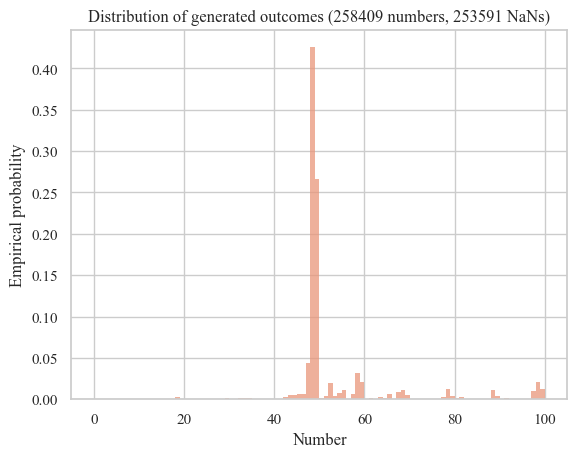

In [ ]:
plot_distribution(
    dist_vanilla,
    n_max=n_max,
    model_name="Vanilla Model",
    color="darksalmon",
    xlims=(-5, 105),
    number_of_NaNs=number_of_NaNs_vanilla,
)

In [34]:
if not os.path.exists("plots"):
    os.makedirs("plots")

df_inference = pd.DataFrame(dist_inference, columns=["Generated Numbers"])
df_inference.to_csv(
    f"plots/GFN_nb-numbers_{number_of_numbers}_nb-NaNs_{number_of_NaNs_inference}_{ckpt_name}.csv",
    index=False,
)

# df_vanilla = pd.DataFrame(dist_vanilla, columns=["Generated Numbers"])
# df_vanilla.to_csv(
#     f"plots/Vanilla_nb-numbers_{number_of_numbers_vanilla}_nb-NaNs_{number_of_NaNs_vanilla}_{ckpt_name}.csv",
#     index=False,
# )

[]

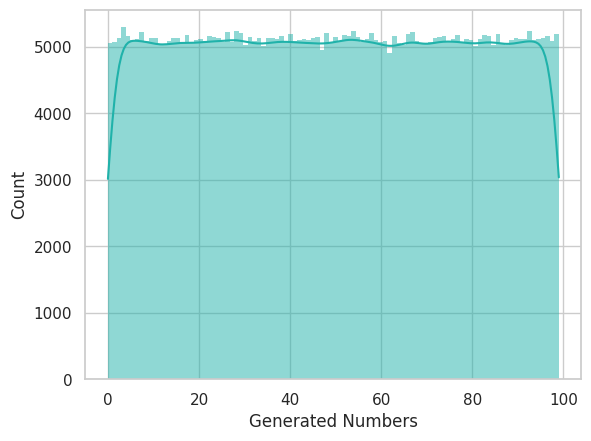

In [66]:
# Count the values with Counter
from collections import Counter

df_inference = pd.read_csv("dist_inference.csv")

Counter(df_inference["Generated Numbers"].to_list())

# Plot
sns.set_theme(style="whitegrid")
plot = sns.histplot(
    df_inference["Generated Numbers"],
    kde=True,
    color="lightseagreen",
    linewidth=0,
    bins=n_max,
)

plt.plot()

<Axes: title={'center': 'Distribution of generated numbers between 0 and 100 (512000 samples)'}, xlabel='Number', ylabel='Count'>

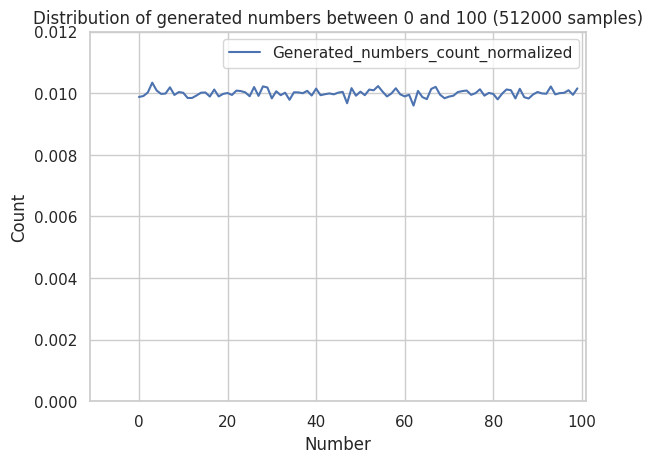

In [67]:
def clean_data(df_inference):
    # Performed 1 aggregation grouped on column: 'Generated Numbers'
    df_inference = (
        df_inference.groupby(["Generated Numbers"])
        .agg(Generated_numbers_count=("Generated Numbers", "count"))
        .reset_index()
    )

    # Normalize Generated_numbers_count into Generated_numbers_count_normalized
    df_inference["Generated_numbers_count_normalized"] = (
        df_inference["Generated_numbers_count"]
        / df_inference["Generated_numbers_count"].sum()
    )

    return df_inference


df_inference_clean = clean_data(df_inference.copy())

df_inference_clean.plot(
    x="Generated Numbers",
    y="Generated_numbers_count_normalized",
    kind="line",
    title=f"Distribution of generated numbers between 0 and {n_max} ({len(dist_inference)} samples)",
    xlabel="Number",
    ylabel="Count",
    xlim=(-11, 101),
    ylim=(0, 0.012),
)